In [1]:
import networkx as nx
from networkx.drawing.nx_agraph import graphviz_layout, to_agraph
from networkx.algorithms.simple_paths import all_simple_paths
import pygraphviz as pgv
from IPython.display import Image
from matplotlib import pyplot as plt
from matplotlib import colors
from random import shuffle
from itertools import cycle, chain
from collections import defaultdict
import json
import yaml

%matplotlib inline

In [2]:
REPO = "koji"

In [3]:
def plt_draw(graph, colors=None, figsize=(30,30)):
    if colors is None:
        colors = ["white" for n in graph.nodes]
    plt.figure(figsize=figsize)
    pos = graphviz_layout(graph, prog="dot")
    nx.draw(graph, with_labels=True, node_color=colors)

In [4]:
css_colors = list(colors.CSS4_COLORS.keys())
shuffle(css_colors)
colors = list(colors.BASE_COLORS.keys()) + css_colors
colors = cycle(colors)

In [5]:
def do_wave(n, color):
    print("Starting wave", n)
    waves[n] = list()
    for package in waves[n-1]:
        print(f"# {package}")
        what_requires = !repoquery --repo={REPO} --qf '%{{NAME}}' --whatrequires {package} 2> /dev/null
        for dependant in what_requires:
            if dependant in binary_exc:
                print("X", dependant, "has an exception")
                continue
            if dependant not in g.nodes:
                print("A", dependant, "→", package)
                waves[n].append(dependant)
                g.add_edge(dependant, package)
                node_colors.append(color)
    print(len(waves[n]), "new packages")
    return len(waves[n])

## Maintainers

In [6]:
with open("../portingdb/data/pagure_owner_alias.json") as fh:
    maintainers = json.load(fh)["rpms"]

inverse_maintainers = defaultdict(list)
for srpm in maintainers:
    for maintainer in maintainers[srpm]:
        inverse_maintainers[maintainer].append(srpm)

## Orphaned packages

In [7]:
srpm_orphans = []
for srpm, srpm_maintainers in maintainers.items():
    if "orphan" in srpm_maintainers:
        srpm_orphans.append(srpm)

## Exceptions

Get groups from portingdb

In [8]:
with open("../portingdb/data/groups.yaml") as fh:
    groups = yaml.load(fh, Loader=yaml.SafeLoader)

Get all non-hidden source RPM packages (have an exception)

In [9]:
source_exc = []
for srpm, info in groups.items():
    if info.get("hidden", False):
        continue
    for package in info["packages"]:
        source_exc.append(package)

In [10]:
source_exc.extend(["mercurial", "autodownloader"])  # manually added exceptions

Get mapping from portingdb to get binary RPMs from source RPMs

In [11]:
with open("../portingdb/_check_drops/results-sources.json") as fh:
    srpm_mapping = json.load(fh)

In [12]:
binary_exc = []
for package in source_exc:
    try:
        binary_exc.extend(srpm_mapping[package])
    except KeyError:
        print(f'{package} not found')

trac-mastertickets-plugin not found


In [13]:
binary_exc.append("python2-capstone")  # Bogus dependencies https://bugzilla.redhat.com/show_bug.cgi?id=1760277#c1
binary_exc.append("python3-dmidecode")  # same as above
binary_exc.append("xed")  # https://lists.fedoraproject.org/archives/list/devel@lists.fedoraproject.org/message/Y6Z6JD3IP6YCF2EQVGCHMRXQ5EJSTIRI/
binary_exc.append("dxf2gcode")
binary_exc.append("mercurial-py2")

In [14]:
print(f"SRPM exceptions - {source_exc}\nRPM exceptions {binary_exc}")

SRPM exceptions - ['gimp', 'gimp-layer-via-copy-cut', 'gimp-resynthesizer', 'pygobject2', 'pygtk2', 'pycairo', 'email2trac', 'babel', 'python-genshi', 'python-jinja2', 'python-markupsafe', 'pytz', 'python2-setuptools', 'trac', 'trac-CGit-plugin', 'trac-accountmanager-plugin', 'trac-batchmodify-plugin', 'trac-blackmagictickettweaks-plugin', 'trac-customfieldadmin-plugin', 'trac-doxygen-plugin', 'trac-git-plugin', 'trac-iniadmin-plugin', 'trac-mastertickets-plugin', 'trac-monotone-plugin', 'trac-navadd-plugin', 'trac-privateticketsplugin', 'trac-sensitivetickets-plugin', 'trac-themeengine-plugin', 'trac-tocmacro-plugin', 'trac-tracnav-plugin', 'trac-vatar-plugin', 'trac-watchlist-plugin', 'trac-workflowadmin-plugin', 'trac-xmlrpc-plugin', 'trac-spamfilter-plugin', 'python-dns', 'python-crypto', 'python-pycryptodomex', 'python2-typing', 'python-httplib2', 'python-oauth2', 'python-pillow', 'python-olefile', 'python2-numpy', 'chromium', 'python-psutil', 'mlt', 'postgresql', 'pypy', 'pypy3',

## Wave #1 - packages directly depending on python27

In [15]:
waves = {}

In [16]:
python27 = !repoquery --repo={REPO} --qf "%{{NAME}}" --whatrequires python27 2> /dev/null

In [17]:
waves[1] = set([p for p in python27 if p not in binary_exc])

In [18]:
g = nx.DiGraph()
node_colors = []

In [19]:
g.add_nodes_from(waves[1])

In [20]:
for package in waves[1]:
    g.add_edge(package, "PY2")
    # g.add_node(package)
    node_colors.append("red")
node_colors.append("red")

In [21]:
len(waves[1])

104

## Wave 2, 3, 4, …

In [22]:
for n in range(2, 20):
    color = next(colors)
    new_pkgs = do_wave(n, color)
    if new_pkgs == 0:
        break

Starting wave 2
# sugar-memorize
# sugar-base
# sugar-castle
# sugar-kuku
# sugar-story
# gnome-python2-gnomekeyring
# sugar-browse
# sugar-speak
# gnome-python2-devel
# sugar-abacus
# sugar-connect
# sugar-log
# sugar-toolkit
# python2-gobject-base
# python2-dbus
A lokalize → python2-dbus
# python2-dateutil
# exaile
# sugar-physics
# sugar-words
# sugar-view-slides
# sugar-visualmatch
# sugar-xomail
# mailman
# sugar-paint
# sugar-clock
# sugar-countries
# sugar-xoeditor
# shedskin
# sugar-runner
A sugar-runner-devel → sugar-runner
# sugar-flipsticks
# sugar-record
# sugar-calculator
# gnome-python2-gnome
A audit-viewer → gnome-python2-gnome
# gourmet
# sugar-getiabooks
# python2-beautifulsoup
# sugar-infoslicer
# sugar-toolkit-gtk3
A sugar → sugar-toolkit-gtk3
A sugar-toolkit-gtk3-devel → sugar-toolkit-gtk3
# sugar-implode
# python2-telepathy
# sugar-playgo
# sugar-jukebox
# sugar-imageviewer
# sugar-recall
# sugar-distance
# fslint
# gnome-python2-rsvg
# sugar-chat
# sugar-moon
# py

## Save

In [23]:
nx.write_adjlist(g, "full_graph.adjlist")

In [24]:
waves[1] = list(waves[1])

In [25]:
with open("wawes.json", "w") as fh:
    json.dump(waves, fh)
with open("node_colors.json", "w") as fh:
    json.dump(node_colors, fh)

## Load

In [26]:
with open("wawes.json") as fh:
    waves = json.load(fh)
with open("node_colors.json") as fh:
    node_colors = json.load(fh)

In [27]:
g = nx.read_adjlist("full_graph.adjlist", create_using=nx.DiGraph())

In [28]:
"PY2" in g.nodes

True

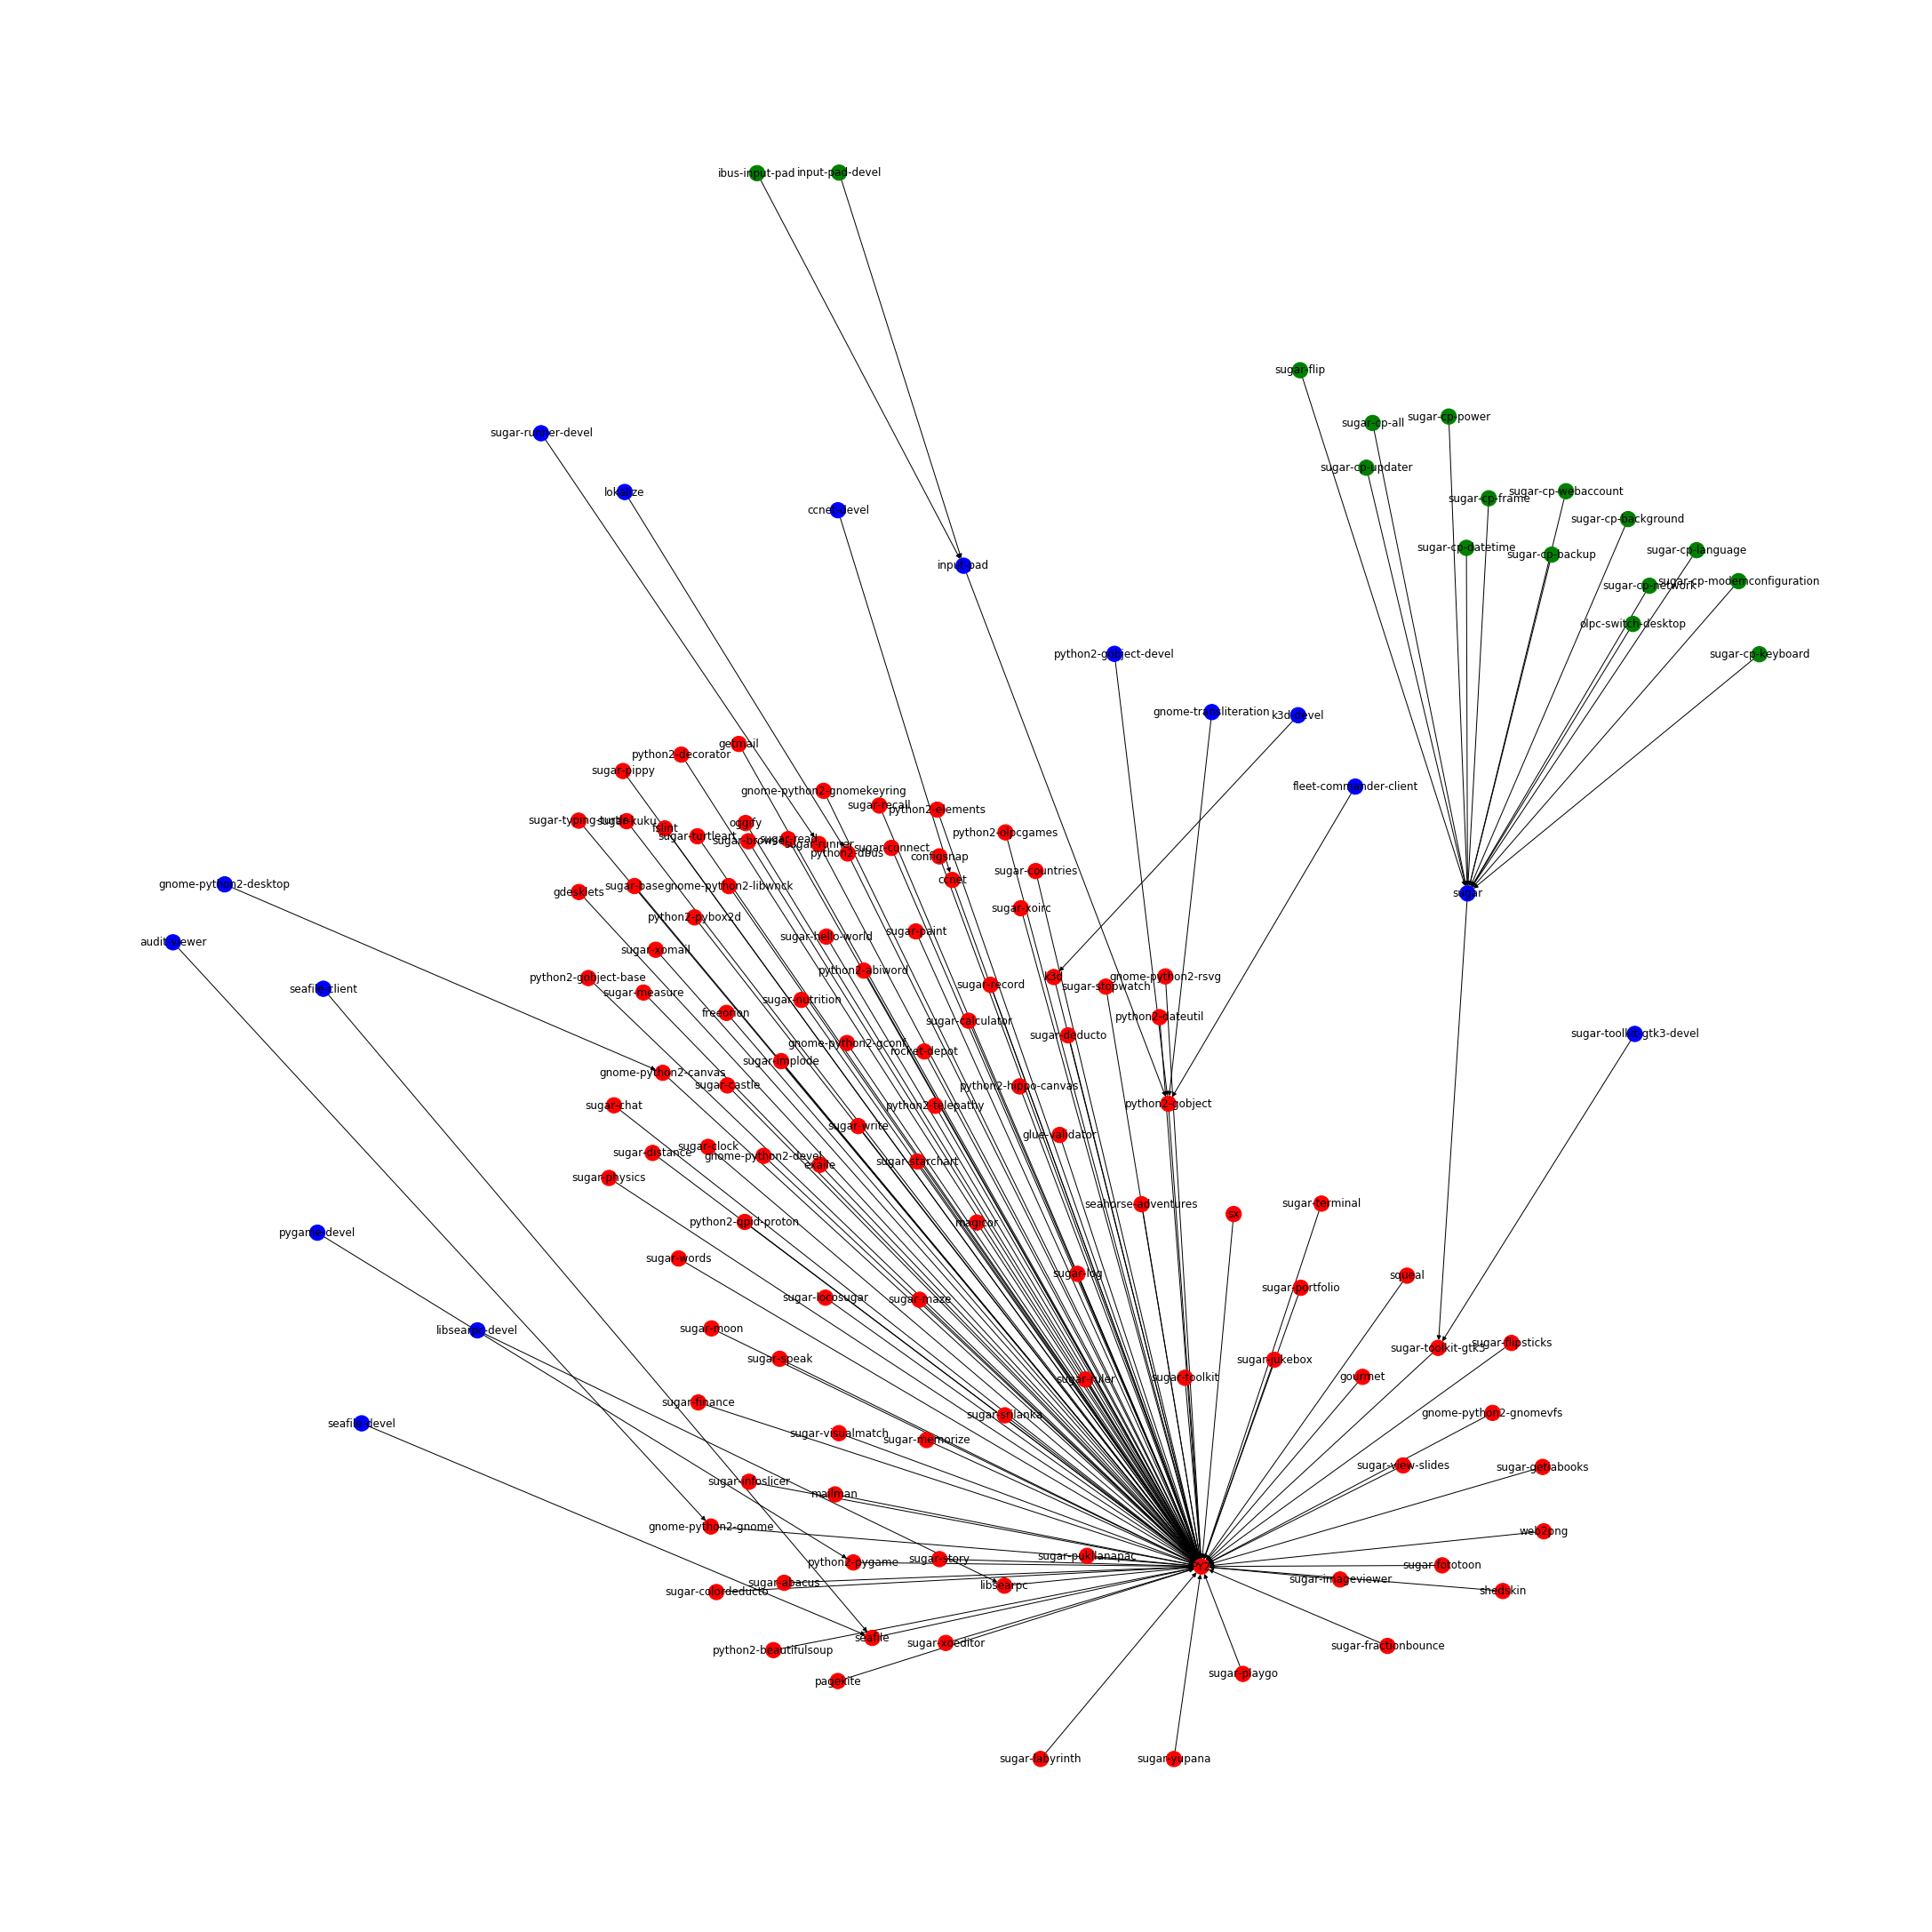

In [29]:
plt_draw(g, node_colors)

## List of packages and theirs paths to Python 2 (including the packages in the first wave)

In [30]:
len(waves)

4

In [31]:
with open("packages.txt", "w") as packages_file:
    binary_packages = list(chain(*[waves[str(n)] for n in waves.keys()]))
    print("Total packages", len(binary_packages))
    for package in sorted(binary_packages):
        path = list(all_simple_paths(g, package, 'PY2'))[0]
        line = f"{package} ({' → '.join(path)})"
        print(line)
        print(line, file=packages_file)

!scp packages.txt fedorapeople.org:public_html/ >/dev/null

Total packages 136
audit-viewer (audit-viewer → gnome-python2-gnome → PY2)
ccnet (ccnet → PY2)
ccnet-devel (ccnet-devel → ccnet → PY2)
configsnap (configsnap → PY2)
exaile (exaile → PY2)
fleet-commander-client (fleet-commander-client → python2-gobject → PY2)
freeorion (freeorion → PY2)
fslint (fslint → PY2)
gdesklets (gdesklets → PY2)
getmail (getmail → PY2)
glue-validator (glue-validator → PY2)
gnome-python2-canvas (gnome-python2-canvas → PY2)
gnome-python2-desktop (gnome-python2-desktop → gnome-python2-canvas → PY2)
gnome-python2-devel (gnome-python2-devel → PY2)
gnome-python2-gconf (gnome-python2-gconf → PY2)
gnome-python2-gnome (gnome-python2-gnome → PY2)
gnome-python2-gnomekeyring (gnome-python2-gnomekeyring → PY2)
gnome-python2-gnomevfs (gnome-python2-gnomevfs → PY2)
gnome-python2-libwnck (gnome-python2-libwnck → PY2)
gnome-python2-rsvg (gnome-python2-rsvg → PY2)
gnome-transliteration (gnome-transliteration → python2-gobject → PY2)
gourmet (gourmet → PY2)
ibus-input-pad (ibus-inp

## List of all SRPMs and theirs RPMs

In [32]:
inverse_srpm_map = {}
for srpm, pkgs in srpm_mapping.items():
    inverse_srpm_map.update({pkg: srpm for pkg in pkgs})

In [33]:
srpms = defaultdict(list)
for package in binary_packages:
    try:
        srpm = inverse_srpm_map[package]
    except KeyError:
        srpm = "N/A"
    srpms[srpm].append(package)

## List of affected maintainers and their binary RPMs

In [34]:
affected_maintainers = defaultdict(list)
for package in binary_packages:
    try:
        srpm = inverse_srpm_map[package]
    except KeyError:
        srpm = "N/A"
    for maintainer in maintainers.get(srpm, []):
        affected_maintainers[maintainer].append(package)

with open("affected_maintainers.txt", "w") as affected_maintainer_file:
    for maintainer, pkgs in sorted(affected_maintainers.items(), key=lambda x: x[0]):
        line = f"{maintainer} - {', '.join(pkgs)}"
        print(line)
        print(line, file=affected_maintainer_file)

!scp affected_maintainers.txt fedorapeople.org:public_html/ >/dev/null

alexl - gnome-python2-gnomekeyring, gnome-python2-devel, python2-dbus, gnome-python2-gnome, gnome-python2-rsvg, gnome-python2-gconf, gnome-python2-canvas, gnome-python2-gnomevfs, gnome-python2-libwnck, gnome-python2-desktop
anishpatil - gnome-transliteration
aperezbios - sugar, sugar-cp-all, sugar-cp-background, sugar-cp-backup, sugar-cp-datetime, sugar-cp-frame, sugar-cp-keyboard, sugar-cp-language, sugar-cp-modemconfiguration, sugar-cp-network, sugar-cp-power, sugar-cp-updater, sugar-cp-webaccount
aruiz - fleet-commander-client
besser82 - python2-dbus
bkearney - sugar-moon, sugar-turtleart
bowlofeggs - rocket-depot
bpepple - python2-telepathy
caillon - gnome-python2-gnomekeyring, gnome-python2-devel, python2-dbus, gnome-python2-gnome, gnome-python2-rsvg, gnome-python2-gconf, gnome-python2-canvas, gnome-python2-gnomevfs, gnome-python2-libwnck, gnome-python2-desktop
callkalpa - sugar-memorize, sugar-castle, sugar-kuku, sugar-browse, sugar-speak, sugar-abacus, sugar-connect, sugar-log, 

## Combined structure

In [35]:
structure = defaultdict(lambda: defaultdict(list))
for binary_pkg in binary_packages:
    try:
        srpm = inverse_srpm_map[binary_pkg]
        srpm_maintainers = maintainers[srpm]
    except KeyError:
        srpm = "N/A"
        srpm_maintainers = ["N/A"]
    for maintainer in srpm_maintainers:
        structure[maintainer][srpm].append(binary_pkg)

# Build dependencies (direct)

In [36]:
srpm_dependants = []
for package in sorted(binary_packages):
    build_requires = !repoquery --repo={REPO}-source --repo={REPO} --qf "%{{NAME}} %{{ARCH}}" --whatrequires {package} 2>/dev/null | grep " src$" | cut -d " " -f 1
    print(f"{package} in required in build time by {build_requires}")
    for srpm in build_requires:
        if srpm in srpms.keys() or srpm in srpm_dependants:
            print(f"✅ {srpm} is already in the graph")
            continue
        if srpm in source_exc:
            print(f"✅ {srpm} in in the list of source ackages with exceptions")
            continue
        try:
            rpms = srpm_mapping[srpm]
        except KeyError:
            print(f"Cannot get RPMs for {srpm}")
            continue
        if any([p.startswith("python2-") for p in rpms]):
            print(f"✅ {srpm} provides python2 subpackage - {rpms}")
            continue
        
        srpm_dependants.append(srpm)
        g.add_edge(srpm, package)
        srpm_maintainers = maintainers[srpm]
        for maintainer in srpm_maintainers:
            structure[maintainer][srpm].insert(0, "SRPM")  # For these special cases, we'll generate path for SRPM

audit-viewer in required in build time by []
ccnet in required in build time by []
ccnet-devel in required in build time by ['seafile', 'seafile-client']
✅ seafile is already in the graph
✅ seafile-client is already in the graph
configsnap in required in build time by []
exaile in required in build time by []
fleet-commander-client in required in build time by []
freeorion in required in build time by []
fslint in required in build time by []
gdesklets in required in build time by []
getmail in required in build time by []
glue-validator in required in build time by []
gnome-python2-canvas in required in build time by ['gnome-python2-desktop']
✅ gnome-python2-desktop is already in the graph
gnome-python2-desktop in required in build time by []
gnome-python2-devel in required in build time by ['gdesklets', 'gnome-python2-desktop']
✅ gdesklets is already in the graph
✅ gnome-python2-desktop is already in the graph
gnome-python2-gconf in required in build time by ['gnome-python2-desktop']

sugar-toolkit-gtk3-devel in required in build time by ['sugar-infoslicer', 'sugar-jukebox', 'sugar-paint', 'sugar-read', 'sugar-record', 'sugar-visualmatch', 'sugar-write', 'sugar-xoirc']
✅ sugar-infoslicer is already in the graph
✅ sugar-jukebox is already in the graph
✅ sugar-paint is already in the graph
✅ sugar-read is already in the graph
✅ sugar-record is already in the graph
✅ sugar-visualmatch is already in the graph
✅ sugar-write is already in the graph
✅ sugar-xoirc is already in the graph
sugar-turtleart in required in build time by []
sugar-typing-turtle in required in build time by []
sugar-view-slides in required in build time by []
sugar-visualmatch in required in build time by []
sugar-words in required in build time by []
sugar-write in required in build time by []
sugar-xoeditor in required in build time by []
sugar-xoirc in required in build time by []
sugar-xomail in required in build time by []
sugar-yupana in required in build time by []
sx in required in build ti

### Save

In [37]:
with open("structure.json", "w") as fh:
    json.dump(structure, fh)

### Load

In [38]:
with open("structure.json") as fh:
    structure = json.load(fh)

# Final outputs

## Package structure with paths

In [39]:
with open("report.txt", "w") as report_file:
    for maintainer in sorted(structure.keys()):
        # Skip orphans and unknown maintainers
        if maintainer in ("N/A", "orphan"):
            continue
        lines = []
        lines.append(maintainer)
        for srpm in sorted(structure[maintainer]):
            # Skip orphaned packages
            if srpm in srpm_orphans:
                continue
            lines.append(f"  {srpm}")
            rpms = sorted(structure[maintainer][srpm])
            if srpm in rpms:
                rpms.remove(srpm)
                rpms.insert(0, srpm)
            for rpm in rpms:
                marker = "→ "
                if rpm == "SRPM":
                    rpm = srpm
                    marker = "BuildRequires: "

                # Mark all orphaned packages in the path by (!)
                path = list(all_simple_paths(g, rpm, 'PY2'))[0]
                for index, package in enumerate(path):
                    try:
                        if inverse_srpm_map[package] in srpm_orphans:
                            path[index] = f"{package} (!)"
                    except KeyError:
                        pass

                if path[0] == srpm:
                    del path[0]
                    str_path = marker + ' → '.join(path)
                    line = f"    ({str_path})"
                else:
                    del path[0]
                    str_path = '→ ' + ' → '.join(path)
                    line = f"    {rpm} ({str_path})"
                lines.append(line)

        if any([True for l in lines if l.startswith(" "*4)]):
            print("\n".join(lines))
            print("\n".join(lines), file=report_file)

!scp report.txt fedorapeople.org:public_html/ >/dev/null

alexl
  dbus
    (BuildRequires: python2-gobject → PY2)
  dbus-python
    python2-dbus (→ PY2)
  gnome-python2
    gnome-python2-canvas (→ PY2)
    gnome-python2-devel (→ PY2)
    gnome-python2-gconf (→ PY2)
    gnome-python2-gnome (→ PY2)
    gnome-python2-gnomevfs (→ PY2)
  gnome-python2-desktop
    (→ gnome-python2-canvas → PY2)
    gnome-python2-gnomekeyring (→ PY2)
    gnome-python2-libwnck (→ PY2)
    gnome-python2-rsvg (→ PY2)
amigadave
  dbus
    (BuildRequires: python2-gobject → PY2)
anishpatil
  gnome-transliteration
    (→ python2-gobject → PY2)
aperezbios
  sugar
    (→ sugar-toolkit-gtk3 → PY2)
    sugar-cp-all (→ sugar → sugar-toolkit-gtk3 → PY2)
    sugar-cp-background (→ sugar → sugar-toolkit-gtk3 → PY2)
    sugar-cp-backup (→ sugar → sugar-toolkit-gtk3 → PY2)
    sugar-cp-datetime (→ sugar → sugar-toolkit-gtk3 → PY2)
    sugar-cp-frame (→ sugar → sugar-toolkit-gtk3 → PY2)
    sugar-cp-keyboard (→ sugar → sugar-toolkit-gtk3 → PY2)
    sugar-cp-language (→ sugar → sugar-

## Recipients

In [40]:
recipients = set(structure.keys())
for recipient in sorted(recipients):
    if recipient in ("N/A", "orphan") or all([srpm in srpm_orphans for srpm in structure[recipient]]):
        continue
    print(f"{recipient}@fedoraproject.org")

alexl@fedoraproject.org
amigadave@fedoraproject.org
anishpatil@fedoraproject.org
aperezbios@fedoraproject.org
aruiz@fedoraproject.org
besser82@fedoraproject.org
bkearney@fedoraproject.org
bowlofeggs@fedoraproject.org
bpepple@fedoraproject.org
caillon@fedoraproject.org
callkalpa@fedoraproject.org
caolanm@fedoraproject.org
cheese@fedoraproject.org
cicku@fedoraproject.org
cjb@fedoraproject.org
corsepiu@fedoraproject.org
ctria@fedoraproject.org
deji@fedoraproject.org
dmalcolm@fedoraproject.org
dsd@fedoraproject.org
dvratil@fedoraproject.org
erikos@fedoraproject.org
fab@fedoraproject.org
fale@fedoraproject.org
fujiwara@fedoraproject.org
gbcox@fedoraproject.org
genodeftest@fedoraproject.org
herrold@fedoraproject.org
hguemar@fedoraproject.org
huzaifas@fedoraproject.org
jgrulich@fedoraproject.org
johnp@fedoraproject.org
jraber@fedoraproject.org
jreznik@fedoraproject.org
jskarvad@fedoraproject.org
jspaleta@fedoraproject.org
jujens@fedoraproject.org
jwrdegoede@fedoraproject.org
kevin@fedoraproje

## Save

In [41]:
nx.write_adjlist(g, "full_graph.adjlist")

### Packages to retire

In [42]:
to_retire = set()
to_subdrop = dict()
for binary_pkg in binary_packages:
    try:
        srpm = inverse_srpm_map[binary_pkg]
    except KeyError:
        continue
    to_subdrop[srpm] = set()
    siblings = set(srpm_mapping[srpm])
    for sibling in siblings:
        if sibling in binary_packages:
            to_subdrop[srpm].add(sibling)
    if to_subdrop[srpm] == siblings:
        to_retire.add(srpm)

for srpm in sorted(to_retire):
    print(srpm)

audit-viewer
ccnet
configsnap
exaile
fleet-commander-client
fslint
gdesklets
getmail
glue-validator
gnome-python2-desktop
gnome-transliteration
gourmet
ibus-input-pad
input-pad
k3d
libsearpc
lokalize
magicor
mailman
oggify
olpc-switch-desktop
pagekite
python-BeautifulSoup
python-elements
python-olpcgames
python-telepathy
rocket-depot
seafile
seafile-client
seahorse-adventures
shedskin
squeal
sugar
sugar-abacus
sugar-base
sugar-browse
sugar-calculator
sugar-castle
sugar-chat
sugar-clock
sugar-colordeducto
sugar-connect
sugar-countries
sugar-deducto
sugar-distance
sugar-finance
sugar-flip
sugar-flipsticks
sugar-fototoon
sugar-fractionbounce
sugar-getiabooks
sugar-hello-world
sugar-imageviewer
sugar-implode
sugar-infoslicer
sugar-jukebox
sugar-kuku
sugar-labyrinth
sugar-locosugar
sugar-log
sugar-maze
sugar-measure
sugar-memorize
sugar-moon
sugar-nutrition
sugar-paint
sugar-physics
sugar-pippy
sugar-playgo
sugar-portfolio
sugar-pukllanapac
sugar-read
sugar-recall
sugar-record
sugar-ruler
s

### Subpackages to drop

In [44]:
for srpm in sorted(to_subdrop):
    if srpm in to_retire:
        continue
    subpkgs = ', '.join(sorted(to_subdrop[srpm]))
    print(f'"{srpm}": {sorted(to_subdrop[srpm])},')

"abiword": ['python2-abiword'],
"dbus-python": ['python2-dbus'],
"freeorion": ['freeorion'],
"gif2png": ['web2png'],
"gnome-python2": ['gnome-python2-canvas', 'gnome-python2-devel', 'gnome-python2-gconf', 'gnome-python2-gnome', 'gnome-python2-gnomevfs'],
"hippo-canvas": ['python2-hippo-canvas'],
"pybox2d": ['python2-pybox2d'],
"pygame": ['pygame-devel', 'python2-pygame'],
"pygobject3": ['python2-gobject', 'python2-gobject-base', 'python2-gobject-devel'],
"python-dateutil": ['python2-dateutil'],
"python-decorator": ['python2-decorator'],
"qpid-proton": ['python2-qpid-proton'],
